This notebook reads in previously downsampled data and does a simple least-squares slip inversion.

In [1]:
%matplotlib inline
# External libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import requests

matplotlib.rcParams['figure.figsize'] = (30,30) # make the plots bigger

In [2]:
# CSI routines
import csi.planarfault as pf
import csi.gps as gr
import csi.insar as insar
import csi.geodeticplot as geoplt
import csi.seismiclocations as sl
import csi.imagedownsampling as imagedownsampling
import csi.fault3D as flt3D
import csi.faultwithvaryingdip as flt
import csi.verticalfault as verticalfault
#import csi.cosicorrrates as cr
import csi.imagecovariance as imcov
import csi.multifaultsolve as multifaultsolve
import csi.transformation as transformation
import csi.faultpostproc as faultpp

You should have already completed the downsampling notebook. These flags control what parts of the slip inversion and plotting is done.

In [3]:
# if not doSolve then read previous solution
doSolve = True
check_geometry = True
plotSAR = True
plotGPS = False
plotSlip = True
save_iCd = False

CSI does most computations in a local Cartesian coordinate system and these projection parameters better be the same as what was used in the downsampling. 

In [4]:
# UTM zone 11 for eastern California
utmzone = 11
# center for local coordinates--M7.1 epicenter from Zach Ross catalog
lon0 = -117.5995
lat0 = 35.7678

For this example, we will use an InSAR dataset for the 2019 Ridgecrest earthquake, published online at the Harvard Dataverse:

Fielding, Eric Jameson, 2019, "Replication Data for: Surface deformation related to the 2019 Mw 7.1 and Mw 6.4 Ridgecrest Earthquakes in California from GPS, SAR interferometry, and SAR pixel offsets", https://doi.org/10.7910/DVN/JL9YMS, Harvard Dataverse, V2

The dataset we will work with is an ALOS-2 wide-swath interferogram from descending track 166.

We set the output name of the downsampled dataset that we will read in.

In [5]:
# set the downsampled (varres) name root
varresA2 = 'A2D166_ifg'  # ALOS-2 Descending track 166

We instantiate a new `insar` object and read in the downsampled data with the associated data covariance matrix.

In [6]:
#--------------------------------------------------------------------
# Initialize the InSAR data

# use data covariance from downsampling
#---------------------------------------------------------------
# Create insar objectS
sarAd1 = insar('A2D166_ifg', utmzone=utmzone, lon0=lon0, lat0=lat0)
sarAd1.read_from_varres(varresA2, cov=True)

---------------------------------
---------------------------------
Initialize InSAR data set A2D166_ifg
Read from file A2D166_ifg into data set A2D166_ifg


We add the dataset `sarAd1` to a list of InSAR datasets. In most cases, there will be more than one dataset.

In [7]:
insardata = [sarAd1]

In this example, we don't have any GPS (GNSS) data, so we set that to an empty list.

In [8]:
gpsdata = []

We combine the InSAR and GPS data into a list of all geodetic datasets.

In [9]:
geodata = insardata + gpsdata 

The new version of CSI has a `transformation` class for dealing with data transformation nuisance parameters. We need to setup a list of the transformations for each geodetic dataset. In this case, we will only use a constant (order 1) for the InSAR dataset.

In [10]:
transformations = [1]   # estimate constant offset for InSAR

Now we instantiate the `transformation` object.

In [11]:
#---------------------------------
# Create transformation object

trans = transformation('Orbits and reference frame', lon0=lon0, lat0=lat0, utmzone=utmzone, verbose=True)

---------------------------------
---------------------------------
Initializing transformation Orbits and reference frame


For this example, we will create the fault object from the same simplified version of the main fault rupture that was used for the initial downsampling, represented by three points in `Approx-main-rupture.txt` as the surface trace of the fault, and approximate it as a vertical fault.

The `verticalfault` class is a class inherited from `RectangularPatches` class to generate a model vertical fault as a set of rectangular patches. The `RectangularPatches` class is in turn a subclass of the `Faults` class. The first parameter is the fault name. The local coordinate system for the CSI calculations is specified by the UTM zone and center point.

In [12]:
faultTrace = 'Approx-main-rupture.txt'
fault = verticalfault('Ridgecrest_main', utmzone=utmzone, lon0=lon0, lat0=lat0)

---------------------------------
---------------------------------
Initializing fault Ridgecrest_main


We load the surface trace points from the file into the trace of the fault object with the `file2trace` method and then interpolate between the points with the `discretize` method to densify the trace every 2 km. The interpolation method works better if we tell it which direction 'x' or 'y' to work along as the `xaxis`. In this case, the main Ridgecrest rupture is more north-south.

In [13]:
# load fault trace from file
fault.file2trace(faultTrace)
# fault mostly north-south
fault.discretize(every=2.0,xaxis='y')

Now we use `setDepth` method to set the depth to which the fault will extend (first parameter), the depth of the top, and the number of patches down-dip. For this rough fault, we use 2 km patch size.

Then we use the `build_patches` method to generate all the rectangular patches. We run the `initializeslip` method to set the initial slip values on all patches to zero.

In [14]:
# Set max depth of 20 km and number of fault patches down-dip as 10 (2 km patches)
fault.setDepth(20.0, top=0.0, num=10)
# Build the patches
fault.build_patches()
# Initialize the slip vector to zero
fault.initializeslip()

Build patches for fault Ridgecrest_main between depths: 0.0, 20.0


The patches are kept in the `patch` array of the fault, so we can see the total number of patches in the model fault by checking its length.

In [15]:
numPatches = len(fault.patch)
numPatches

230

Now we define the area we will be using for the analysis and for the plotting. These are the same for now.

In [16]:
# Box for Ridgecrest area data cropping
minlat = 35.3
maxlat = 36.2
minlon = -118.1+360.
maxlon = -117.1+360.

# Box for plotting (same for now)
plotMinLat = minlat
plotMaxLat = maxlat
plotMinLon = minlon
plotMaxLon = maxlon

We can use the `geodeticplot` class to make map and 3D plots of the fault. We need to tell it the plotting area when we create the plotting object. The `faulttrace` method loads the trace into the plots, and the `faultpatches` method loads the fault patches.

Then we can plot the fault trace in the map view with the `show` method. The `showFig` parameter says to only plot the map view and `fitOnBox` parameter tells it to plot the area of the box we specified.

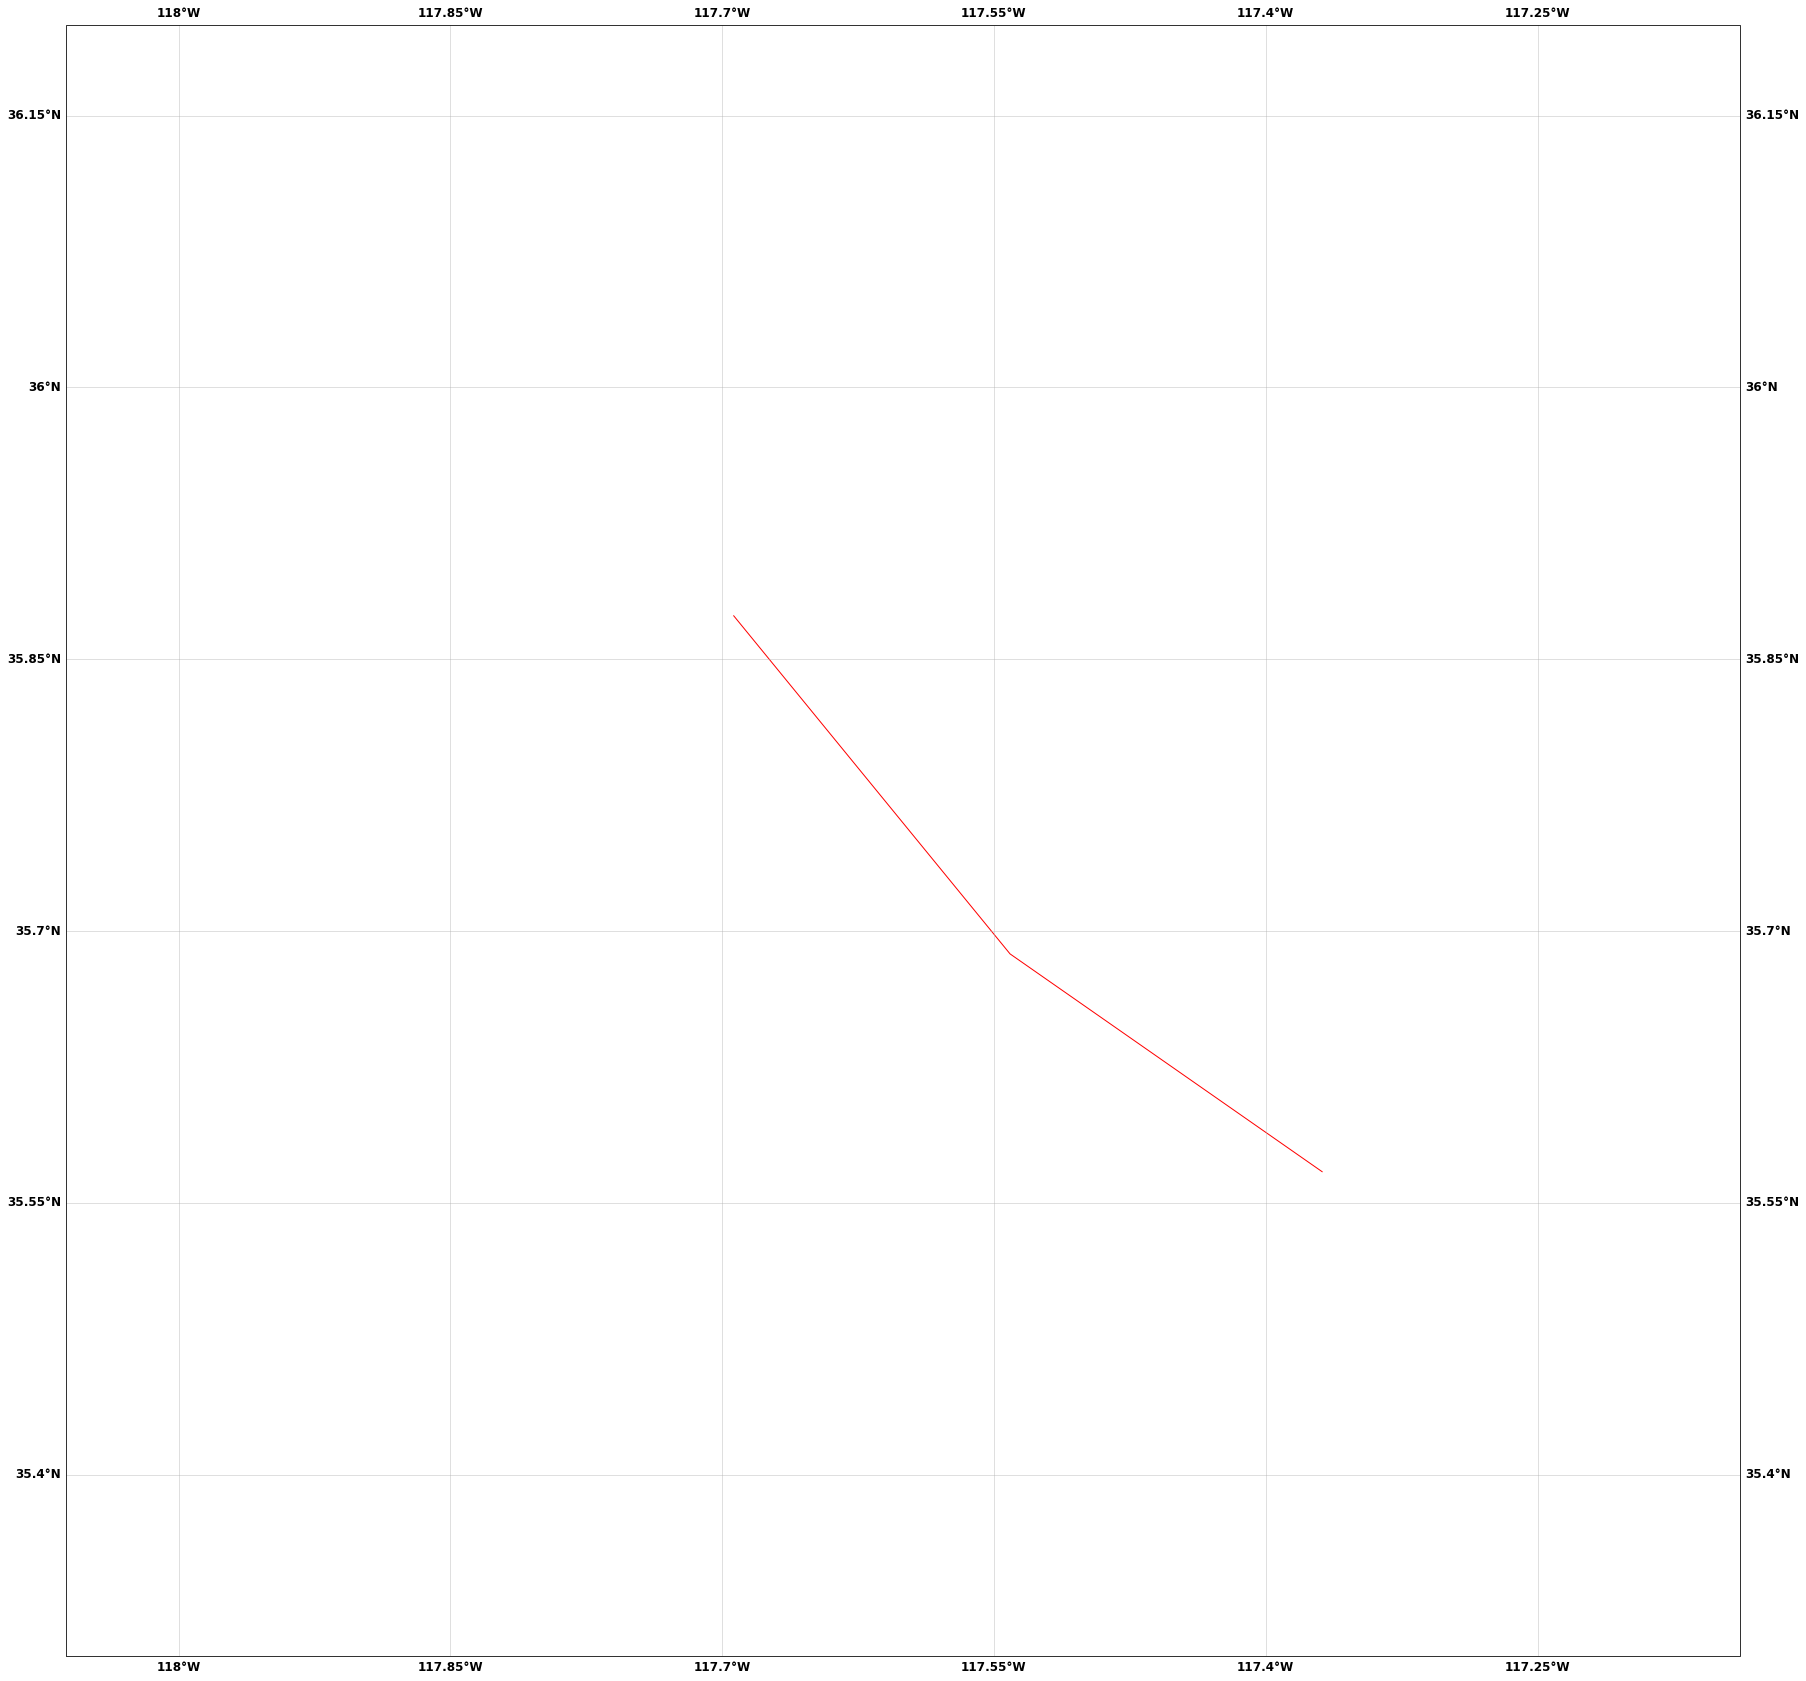

In [17]:
# View the fault trace
gp = geoplt(plotMinLon, plotMinLat, plotMaxLon, plotMaxLat, figure=1)
gp.faulttrace(fault, color='r')
gp.faultpatches(fault, slip='total')
gp.show(mapaxis='equal', showFig=['map'], fitOnBox=True) 

We can write out the fault patches as a set of polygons in the GMT vector file format for plotting.

In [18]:
# Write to file for plotting in GMT
faultGeoOut = 'fault_rect.gmt'
fault.writePatches2File(faultGeoOut)

Writing geometry to file fault_rect.gmt


The slip inversiom and most other CSI classes are designed to work with a set of faults contained in a Python list object, so we need to make a list out of our one fault. In other situations, we could use multiple faults in the list.

In [19]:
faults = [fault]

Now we can calculate the Green's functions (GFs) between slip on each patch of each fault and each of the datasets, using the `buildGFs` method of the `Fault` class. We use a outer loop to calculate these in case there is more than one fault and an inner loop over each dataset. For InSAR data, we want to use `vertical=True`. For some GPS datasets we only have horizontal displacements, so we could set that to False. We also specify the slip direction we want to allow. For this example, we will only use strike-slip direction slip so `slipDir='s'`. The default for Green's functions is to use the Okada (1992) equations for homogeneous elastic half-space. The whole set of Green's functions is the matrix `G` in the classic `Gm=d` equation.

In [20]:
#---------------------------------
# Set up GFs
slipDir = 's'
for fault in faults:
    for data in geodata:
        fault.buildGFs(data, vertical=True, slipdir=slipDir)

Greens functions computation method: Okada
---------------------------------
---------------------------------
Building Green's functions for the data set 
A2D166_ifg of type insar in a homogeneous half-space
 Patch: 230 / 230  


We also need to generate the transformation Green's functions for all the geodetic datasets with the `buildGFs` method of that class.

In [21]:
 trans.buildGFs(geodata, transformations)

Now we need to do what CSI calls the assemble steps for the Green's functions matrix `G`, data `d`, and data covariance `Cd` on each fault and on the transformation object.

In [22]:
#---------------------------------
# Assemble the Green's functions, data, and data covariance

for fault in faults:
    fault.assembleGFs(geodata, slipdir=slipDir)
    fault.assembled(geodata)
    fault.assembleCd(geodata)
trans.assembleGFs(geodata)
trans.assembled(geodata)
trans.assembleCd(geodata)


---------------------------------
---------------------------------
Assembling G for fault Ridgecrest_main
Dealing with A2D166_ifg of type insar
---------------------------------
---------------------------------
Assembling d vector
Dealing with data A2D166_ifg
---------------------------------
---------------------------------
Assembling G for transformation Orbits and reference frame
---------------------------------
---------------------------------
Assembling d vector
Dealing with data A2D166_ifg


The next step is to build the model covariance matrix `Cm`. For the least squares slip inversions, the `Cm` is what applies a regularization or smoothing on the slip. We will use an exponential function of distance for the regularization from the Radiguet, et al. (2011) paper, which uses two parameters. As we are only allowing strike-slip motion, we only need `Cm` paramters for the strike-slip component.

In [23]:
Cm_sigmaS=5.    # something like the expected sigma in meters--"strike" stronger smoothing
Cm_lamS=5.       # smoothing distance in km, will be normalized by lam0 calculated from patch spacing

We build up the `Cm` for each fault and for the transformation.

In [24]:
#---------------------------------------------------------------
# Build the model covariance matrix

# This command allows to build a model covariance matrix including 
# a distance-based smoothing. The function is an exponential.
# The first parameter is the amplitude of the correlation and the second
# is the wavelength.
# One parameter per Slip direction

for fault in faults:
    fault.buildCmSlipDirs([Cm_sigmaS], [Cm_lamS])
trans.buildCm(1.)


---------------------------------
---------------------------------
Assembling the Cm matrix 
Sigma = [5.0]
Lambda = [5.0]



The least-squares slip inversion solver is implemented by the `multifaultsolve` class. We instantiate an object from that class with the list of faults and the transformation. The transformation is not a fault, so there is a warning.

In [25]:
#--------------------------------------------------------------------
# Create a solver and solve

slv = multifaultsolve('Ridgecrest', faults+[trans])

---------------------------------
---------------------------------
Initializing solver object
Not a fault detected


Now we can assemble all the Green's functions in the solver and the model covariance matrix.

In [26]:
slv.assembleGFs()
slv.assembleCm()

Number of data: 465
Number of parameters: 231
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Ridgecrest_main               ||   0 -  230 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Orbits and reference frame    ||None        ||None        ||None        ||None        || 230 -  231 


The solver reports the total number of data samples, and the total parameters in the model. We are only solving for strike-slip, so the number of slip parameters is the same as the number of patches. There is one additional transformation parameter in this simple case.

Now we are finally ready to run the slip inversion. The `multifaultsolve` class has a number of inversion methods. We will use a basic method `GeneralizedLeastSquareSoln` that has this description:

    def GeneralizedLeastSquareSoln(self, mprior=None, rcond=None, useCm=True):
        '''
        Solves the generalized least-square problem using the following formula (Tarantolla, 2005,         Inverse Problem Theory, SIAM):

            :math:`\\textbf{m}_{post} = \\textbf{m}_{prior} + (\\textbf{G}^t \\textbf{C}_d^{-1} \\textbf{G} + \\textbf{C}_m^{-1})^{-1} \\textbf{G}^t \\textbf{C}_d^{-1} (\\textbf{d} - \\textbf{Gm}_{prior})`


In [27]:
# Do least squares solution
slv.GeneralizedLeastSquareSoln()

---------------------------------
---------------------------------
Computing the Generalized Inverse
Computing the inverse of the model covariance
Computing the inverse of the data covariance
Computing m_post
Compute cost function
6.22817634394949
Magnitude is
7.222968927408389


Now we distribute the solution model `m` back onto the original set of faults that we provided to the solver object with the `distributem` method.

In [28]:
# Distribute the slip values to the patches
slv.distributem()

Now we can plot the results with the `geodeticplot` class.

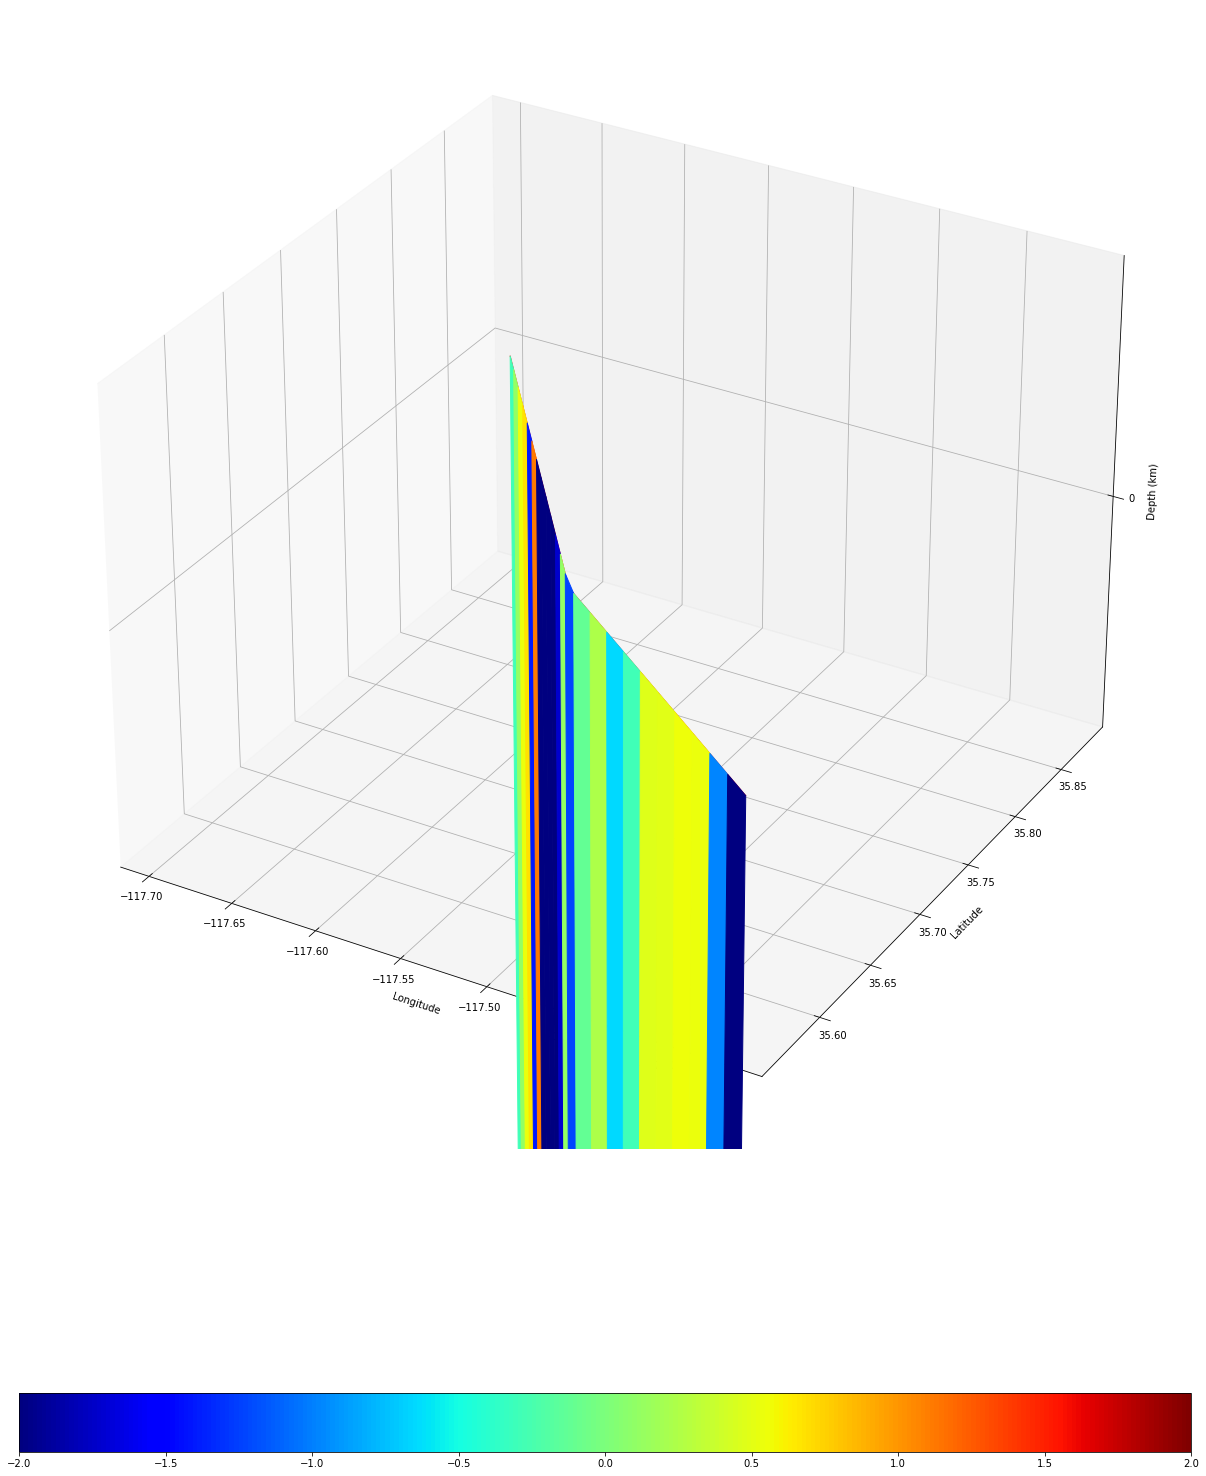

In [30]:
if plotSlip:
# now plot fault slip components
    slipMode=slipDir  # we have only one slip direction in this example
    gp = geoplt(figure=1,latmin=plotMinLat,lonmin=plotMinLon,latmax=plotMaxLat,lonmax=plotMaxLon)
    gp.drawCoastlines(parallels=0.2, meridians=0.2, drawOnFault=True, resolution='fine')
    gp.faulttrace(fault, color='r',add=False)
    gp.faultpatches(fault, norm=[-2.0,2.0], colorbar=True, slip=slipMode, plot_on_2d=False, revmap=True)
    gp.setzaxis(40.0, [0, 10, 20, 30, 40])
#
    gp.savefig(slipMode+'View', dpi=400,saveFig=['fault'])
    gp.show(showFig=['fault'], fitOnBox=False)
    gp.clf()